In [69]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [71]:
ticker = 'AAPL'
df = yf.download(ticker, '2020-01-01')

C:\Users\anike\AppData\Local\Temp\ipykernel_19688\2867026071.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [72]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.468246,72.528566,71.223244,71.476585,135480400
2020-01-03,71.763733,72.523762,71.539345,71.696175,146322800
2020-01-06,72.335548,72.374154,70.634532,70.885464,118387200
2020-01-07,71.995354,72.600960,71.775789,72.345204,108872000
2020-01-08,73.153503,73.455103,71.698589,71.698589,132079200
...,...,...,...,...,...
2025-11-28,278.850006,279.000000,275.989990,277.260010,20135600
2025-12-01,283.100006,283.420013,276.140015,278.010010,46587700


<Axes: xlabel='Date'>

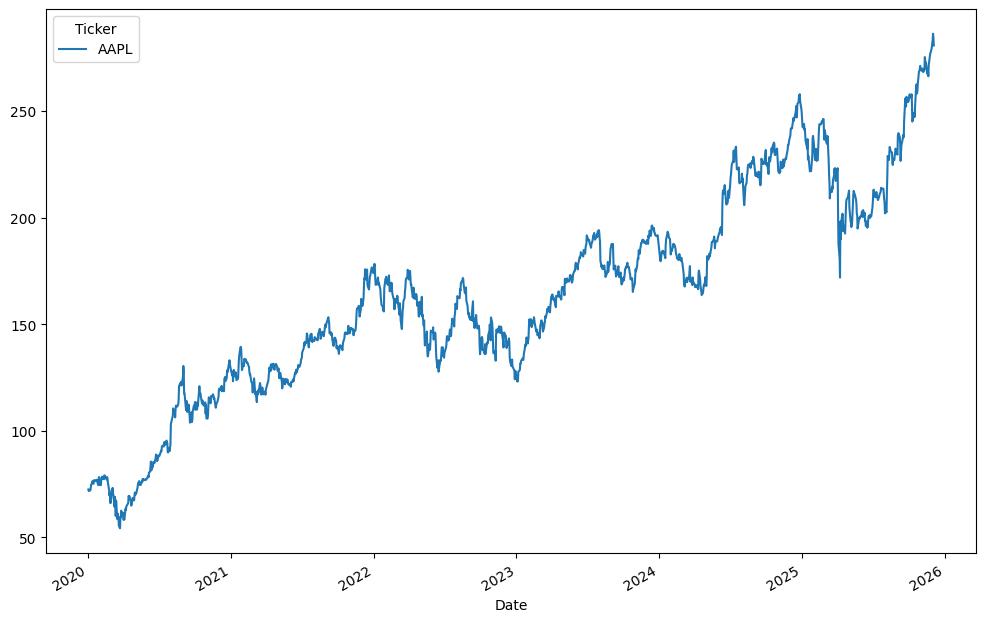

In [73]:
df.Close.plot(figsize=(12,8))

In [74]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close']) # mean=0 and sd=1

In [75]:
df['Close']

Ticker,AAPL
Date,
2020-01-02,-1.879119
2020-01-03,-1.893644
2020-01-06,-1.881855
2020-01-07,-1.888869
2020-01-08,-1.864992
...,...
2025-11-28,2.375700
2025-12-01,2.463319
2025-12-02,2.527023


In [76]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

In [77]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [78]:
class PredictionModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :]) 
        
        return out


In [79]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [80]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [81]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.6269062757492065
25 0.01586293801665306
50 0.005790536757558584
75 0.005060285795480013
100 0.004685035441070795
125 0.004388043656945229
150 0.004122938960790634
175 0.0038809189572930336


In [82]:
model.eval()

y_test_pred = model(X_test)
 
y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [83]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

In [84]:
train_rmse

2.938147783279419

In [85]:
test_rmse

7.139442443847656

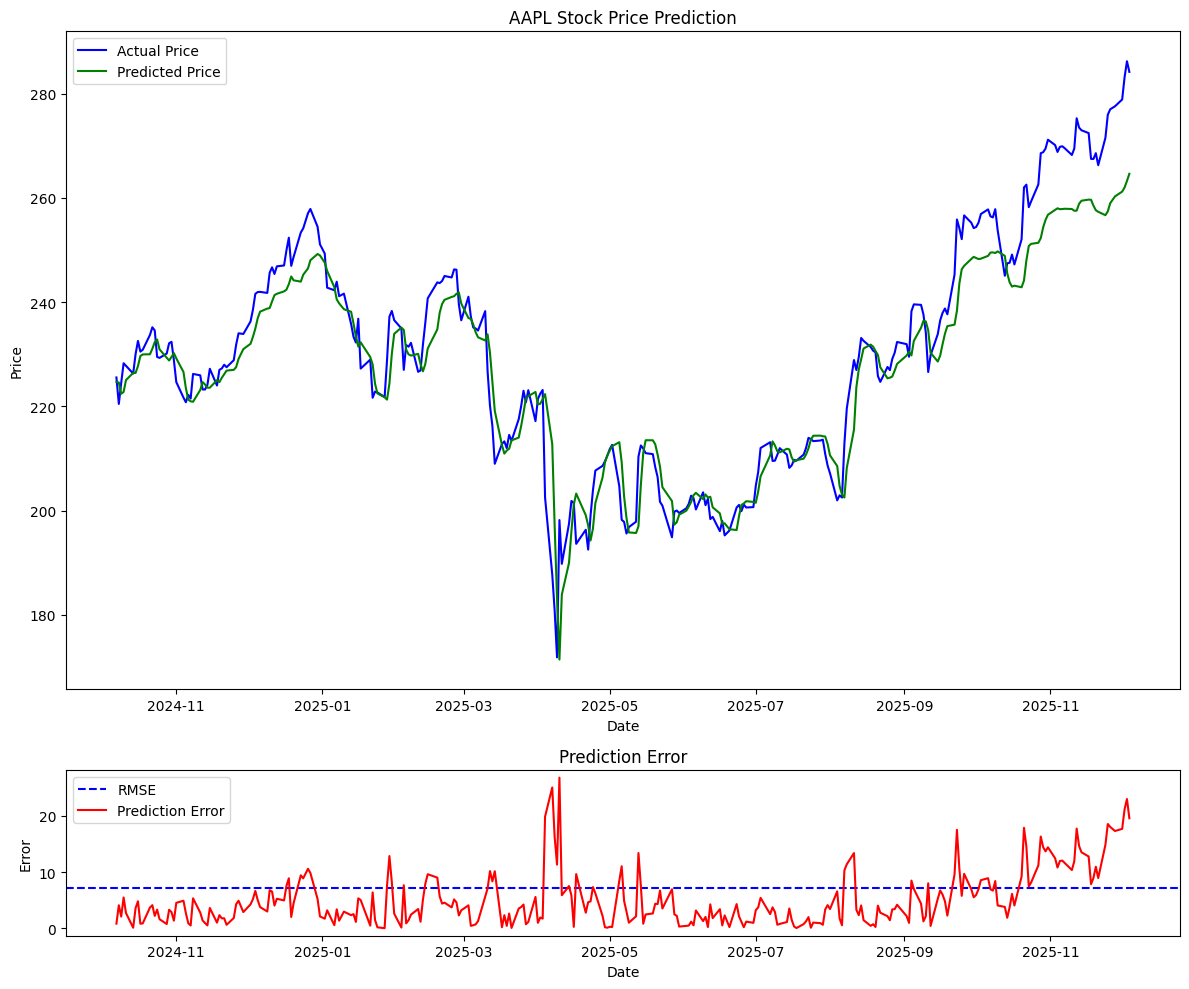

In [86]:
fig = plt.figure(figsize=(12,10))

gs = fig.add_gridspec(4, 1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color='blue', label='Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color='green', label='Predicted Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3,0])
ax2.axhline(test_rmse, color='blue', linestyle='--', label='RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label='Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')

plt.tight_layout()
plt.show()